A significant challenge in analyzing seismic signals arises from the fact that the data captured by a seismograph does not accurately reflect the true underground seismic activity we aim to identify. **In the field of seismology, researchers generate artificial signals known as impulse signals. These artificially created signals interact with the genuine seismic waves produced by the Earth, resulting in the composite signal detected by our seismographs**. This interaction is similar to what occurs in laboratory earthquake simulations. Consequently, the main difficulty lies in isolating the genuine seismic signal from the mixed seismogram, which consists of both the Earth's natural impulses and the artificial signals.

Identifying this underlying signal is crucial, as it offers a more precise prediction of earthquake timing compared to the unprocessed raw data, as it accurately reflects the seismic activity occurring beneath the surface.

### Import Required Libraries
In this section, we will import the essential libraries needed for our analysis and processing of seismic data.

In [42]:
import os                    # For interacting with the operating system
import gc                    # For garbage collection to free up memory
import numpy as np           # For numerical operations and handling arrays
from numpy.fft import *      # For Fast Fourier Transform functions
import pandas as pd          # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
%matplotlib inline           # To display plots inline within the Jupyter notebook
import seaborn as sns       # For enhanced data visualization
import pywt                  # For wavelet transformations
from statsmodels.robust import mad  # For calculating the Mean Absolute Deviation
import scipy                 # For scientific computing
from scipy import signal     # For signal processing functions
from scipy.signal import butter, deconvolve  # For Butterworth filters and deconvolution
import warnings              # For managing warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


UsageError: unrecognized arguments: # To display plots inline within the Jupyter notebook


### Define Segment Size for Seismic Signals and Sampling Rate for High-Pass Filter

In [43]:
# Length of each seismic signal segment
SIGNAL_LEN = 150000  

# Sampling rate in Hertz (samples per second) for the high-pass filter
SAMPLE_RATE = 4000 

### Load Seismic Signal Data from CSV File

In [45]:
# Read the seismic signal data from a CSV file with specified data types for each column
seismic_signals = pd.read_csv('xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', dtype={'velocity(m/s)': np.float32, 'time_rel(sec)': np.float32})

# Display the names of the columns in the DataFrame
print(seismic_signals.columns)


Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


### Extract seismic data and targets and delete the original dataframe

In [46]:
# Extract velocity data and time relative to failure from the DataFrame
velocity_data = seismic_signals['velocity(m/s)']
time_to_failure = seismic_signals['time_rel(sec)']

# Get the length of the DataFrame for future processing
data_length = len(seismic_signals)

# Release memory by deleting the original DataFrame
del seismic_signals

# Perform garbage collection to free up memory
gc.collect()


3994

### Cut out segments of size 150k from the signal

In [47]:
# Create empty lists to store the extracted segments and their corresponding target values
segments = []
targets = []

# Loop through the data to extract segments of specified size
for i in range(data_len // SIGNAL_LEN):
    # Define the lower and upper limits for each segment
    lower_limit = SIGNAL_LEN * i
    upper_limit = min(SIGNAL_LEN * (i + 1), data_len)
    
    # Append the segment of acoustic data and the corresponding target value
    segments.append(list(velocity_data[lower_limit: upper_limit]))
    targets.append(time_to_failure[upper_limit])

# Clean up memory by deleting the original data arrays
del velocity_data
del time_to_failure
gc.collect()

# Convert the list of segments and targets into numpy arrays for further processing
segments = np.array(segments)
targets = np.array(targets)


### Mean Absolute Deviation (MAD)
The Mean Absolute Deviation (MAD) is a statistical measure that quantifies the average of the absolute differences between each value in a time series and the mean of that series. It serves as an indicator of the dispersion or disorder within the data. A higher MAD value implies greater variability and unpredictability in the time series, suggesting that the values are more dispersed from the mean.

In [48]:
def maddest(data, axis=None):
    """
    Calculate the Mean Absolute Deviation (MAD) of a given array.

    Parameters:
    - data: numpy array or similar structure containing numerical values.
    - axis: Axis along which the MAD is computed. If None, the MAD is computed over the entire array.

    Returns:
    - A float representing the MAD value.
    """
    mean_value = np.mean(data, axis)  # Compute the mean of the data along the specified axis
    absolute_deviation = np.absolute(data - mean_value)  # Calculate the absolute deviations from the mean
    return np.mean(absolute_deviation, axis)  # Return the mean of the absolute deviations


### The Butterworth high-pass filter with SOS implementation
A high-pass filter (HPF) is an electronic filter designed to allow signals with frequencies above a specified **cutoff frequency** to pass through, while attenuating (reducing the amplitude of) signals with frequencies below this threshold. The degree of attenuation for each frequency is determined by the specific design of the filter.

In this context, an SOS (Second-Order Sections) filter is utilized to apply a standard [IIR filter](https://en.wikipedia.org/wiki/Infinite_impulse_response) accross the [second-order sections](https://edoras.sdsu.edu/doc/matlab/toolbox/signal/basics27.html#973) of the signal.

These filtering techniques are employed sequentially to diminish undesirable low-frequency signals, effectively preparing the data for subsequent wavelet decomposition.

In [52]:
def high_pass_filter(x, low_cutoff=1000, SAMPLE_RATE=SAMPLE_RATE):
    
    
    # Nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high-frequency band.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_signal = signal.sosfilt(sos, x)  # Change signal to x

    return filtered_signal


## Wavelet Denoising
The filtered signals undergo [wavelet](https://en.wikipedia.org/wiki/Wavelet) decomposition to extract wavelet coefficients. It's important to recognize that the raw signals we analyze are a convolution of both artificial and genuine impulse signals. This necessitates the use of "wavelet decomposition," which acts as a form of "deconvolution." Essentially, this process reverses the convolution, enabling us to isolate the authentic Earth impulse from the combined seismogram and the artificial impulses.

We utilize the Mean Absolute Deviation (MAD) to assess the degree of randomness in the signal, which helps in determining an appropriate threshold for the wavelet coefficients. By filtering out lower coefficients from the set of wavelet coefficients, we can reconstruct the actual Earth signal using the remaining significant coefficients. This approach effectively removes the artificial impulse from the seismogram, allowing us to extract the genuine Earth signal.

In [53]:
def denoise_signal(x, wavelet='db4', level=1):
    """
    Denoises the input signal using wavelet decomposition.
    
    Parameters:
    x : array_like
        The input signal to be denoised.
    wavelet : str, optional
        The wavelet type to use for decomposition. Default is 'db4'.
    level : int, optional
        The level of decomposition. Default is 1.

    Returns:
    array_like
        The denoised signal after reconstruction from the wavelet coefficients.
    """
    
    # Decompose the signal to obtain wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate the standard deviation (sigma) for the threshold
    # based on the Mean Absolute Deviation (MAD) of the coefficients
    sigma = (1 / 0.6745) * maddest(coeff[-level])

    # Determine the universal threshold using the calculated sigma
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))

    # Apply hard thresholding to the wavelet coefficients
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal from the modified wavelet coefficients
    return pywt.waverec(coeff, wavelet, mode='per')


### Visualizing Denoising Effects on Seismic Signals

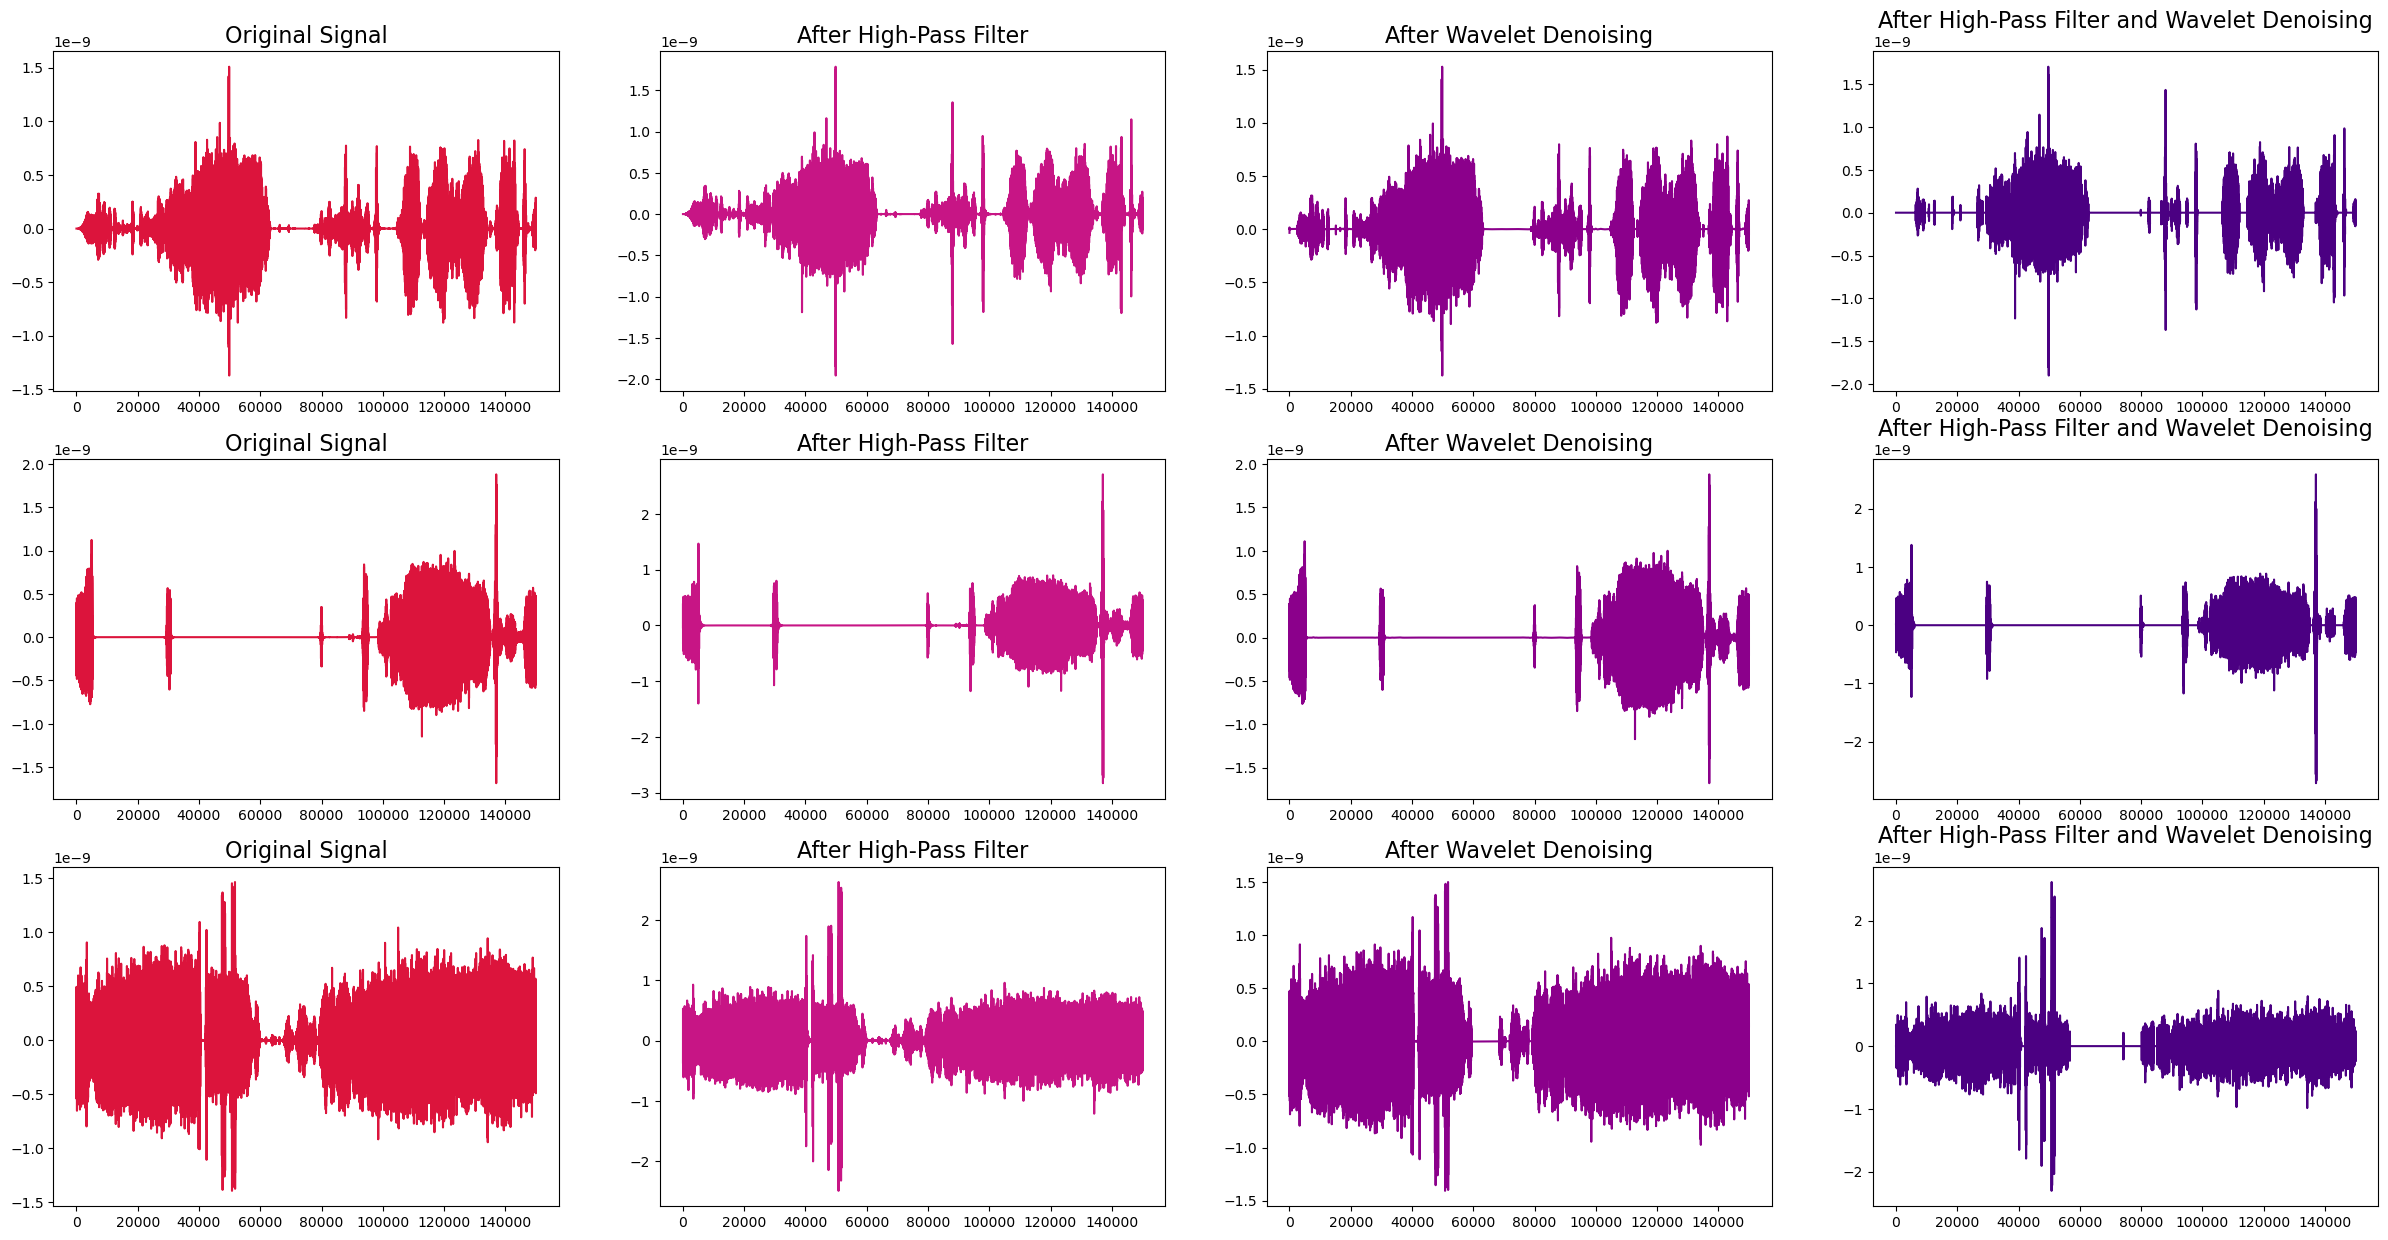

In [55]:
# Create a grid of subplots for visualizing different stages of signal processing
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

# Plotting for the first signal
ax[0, 0].plot(signals[0], color='crimson') 
ax[0, 0].set_title('Original Signal', fontsize=16)

ax[0, 1].plot(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), color='mediumvioletred') 
ax[0, 1].set_title('After High-Pass Filter', fontsize=16)

ax[0, 2].plot(denoise_signal(signals[0]), color='darkmagenta')
ax[0, 2].set_title('After Wavelet Denoising', fontsize=16)

ax[0, 3].plot(denoise_signal(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), color='indigo')
ax[0, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

# Plotting for the second signal
ax[1, 0].plot(signals[1], color='crimson') 
ax[1, 0].set_title('Original Signal', fontsize=16)

ax[1, 1].plot(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), color='mediumvioletred') 
ax[1, 1].set_title('After High-Pass Filter', fontsize=16)

ax[1, 2].plot(denoise_signal(signals[1]), color='darkmagenta')
ax[1, 2].set_title('After Wavelet Denoising', fontsize=16)

ax[1, 3].plot(denoise_signal(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), color='indigo')
ax[1, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

# Plotting for the third signal
ax[2, 0].plot(signals[2], color='crimson') 
ax[2, 0].set_title('Original Signal', fontsize=16)

ax[2, 1].plot(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), color='mediumvioletred') 
ax[2, 1].set_title('After High-Pass Filter', fontsize=16)

ax[2, 2].plot(denoise_signal(signals[2]), color='darkmagenta')
ax[2, 2].set_title('After Wavelet Denoising', fontsize=16)

ax[2, 3].plot(denoise_signal(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), color='indigo')
ax[2, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

# Display the plots
plt.show()


The results clearly demonstrate that both the high-pass filter and wavelet denoising techniques effectively clean the seismic signals by eliminating unnecessary artificial impulses and additional noise. While the high-pass filter alone does not achieve the same level of denoising as wavelet denoising alone, the combination of both methods yields the best results.

1. **High-Pass Filter**: This technique is primarily designed to filter out lower-frequency noise. However, it does not sufficiently address the artificial impulses present in the seismic data.

2. **Wavelet Denoising**: This method excels at performing a sort of deconvolution, effectively isolating and removing the artificial impulse from the signal. As a result, it significantly improves the clarity of the seismic data.

3. **Combined Approach**: When the high-pass filter is applied first, followed by wavelet denoising, the effectiveness of the denoising process is greatly enhanced. This combined approach successfully addresses both the noise from the high-pass filter and the artificial impulses from the wavelet denoising, leading to a much cleaner and more accurate representation of the actual seismic activity.

In summary, while each method has its strengths, their integration provides a comprehensive solution for denoising seismic signals, allowing for improved analysis and interpretation of the underlying geological activity.